# Analysis of the generated results

In this notebook we analyse the results generated with the DataGeneration notebook.

In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

# Utility Functions
The following functions are useful for loading the data.

In [2]:
def load_runs(folder, size, algorithm, nproblems, measurement="val"):
    """
    loads the runs containing for each problem the function value and returns them in a numpy array.
    params:
        folder      -- root folder containing the runs (e.g. ./RUNS/ML/C_01EPS01/)
        size        -- size of the problem whose runs we want to load
        algorithm   -- "ROS" or "GOLD"
        nproblems   -- number of problems in the folder.
        measurement -- column to extract, default: 'val' (function value)
    returns:
        array containing for each problem the function value at each iteration.
    note:
        the function assumes the CSVs containing the results are named 0.csv...(nproblems-1).csv
    """
    if not folder.endswith("/"):
        folder += "/"
    algorithm = "ROS" if algorithm.lower().startswith("r") else "GOLD"
    path = f"{folder}{size}/{algorithm}"
    val_list = []
    for i in range(nproblems):
        filepath = f"{path}/{i}.csv"
        val = pd.read_csv(filepath, usecols=[measurement]).to_numpy()
        val_list.append(val)
    return np.array(val_list)

def load_external_solver_values(folder, size, filename="optimal_values.txt"):
    """
    loads the optimal values computed with the external solver.
    params:
        folder  -- root folder containing the runs.
        size    -- size of the problem
    returns:
        array containing for each problem the optimal value computed by the solver.
    """
    if not folder.endswith("/"):
        folder += "/"
    path = f"{folder}{size}/{filename}"
    
    with open(path, "r") as f:
        opt_vals = f.readlines()
        opt_vals = [np.float64(x.strip()) for x in opt_vals]
        return np.array(opt_vals)

def load_alpha_runs(folder, nproblems):
    """
    loads the runs computed when varying the alpha parameter and returns them in a numpy array.
    folder  -- root folder containing the runs
    returns:
        array containing for each problem the function value at each iteration.
    """
    if not folder.endswith("/"):
        folder += "/"
    
    alpha_values = []
    for i in range(nproblems):
        path = f"{folder}{i}.csv"
        av = pd.read_csv(path, usecols=["val"]).to_numpy().flatten()
        alpha_values.append(av)
    return np.array(alpha_values)

def load_external_solver_alphas(folder, filename="optimal_values.txt"):
    """
    loads the optimal values computed with the external solver.
    params:
        folder  -- root folder containing the runs.
    returns:
        array containing for each problem the optimal value computed by the solver.
    """
    if not folder.endswith("/"):
        folder += "/"
    
    path = f"{folder}{filename}"
    with open(path, "r") as f:
        opt_vals = f.readlines()
        opt_vals = [np.float64(x.strip()) for x in opt_vals]
        return np.array(opt_vals)

In [3]:
def relative_gap(val, opt):
    """
    computes the relative gap between the values at each iteration and the optimal value computed by the external solver.
    params:
        val  -- function values at each iteration
        opt  -- optimal value computed by the external solver
    returns:
        relative gap.
    """
    diff = val - opt
    assert(all(diff > 0))
    return diff / np.abs(opt) if abs(opt) > 1e-3 else diff

def convergence_rate(values, optimal_values):
    """
    computes the convergence rate 
    """
    tmp = values - optimal_values
    res = []
    for l in tmp:
        res.append(l[1:] / l[:-1])
    return np.array(res)

# PATHS
We structured the paths for the problem in the following way:
`RUNS/DATASET/SOLVER PARAMETERS/PROBLEM SIZE/ALGORITHM/PROBLEM NUMBER.csv` where the name of the folder `SOLVER PARAMETER` contains the value of the C (upperbound) and E (epsilon) parameters used by the solver when solving the problems contained in the folder.

In [4]:
rootfolders = "C1EPS_001,C1EPS_01,C_01EPS01,C_05EPS01,C_1EPS01,C_2EPS01,C1EPS_1,C_5EPS01,C_10EPS01".split(",")
rootdataset = "AIRF CAL ML".split(" ")
problem_sizes = [300,400,500, 600]
epsilons = [x for x in rootfolders if "EPS_" in x]
upperbounds = [x for x in rootfolders if "C_" in x]

# ML - UPPERBOUNDS
Here we visualise the relative gap computed on the ML dataset when varying the upperbound parameter. Epsilon was set to $0.1$ while the upperbound C assumed values in [ $0.1$, $1$, $2$, $10$ ]. We decided to insert in the report the most interesting plots, to visualise the plots with other upperbounds it suffices to insert the relative string in  the `chosen_uppers` list.

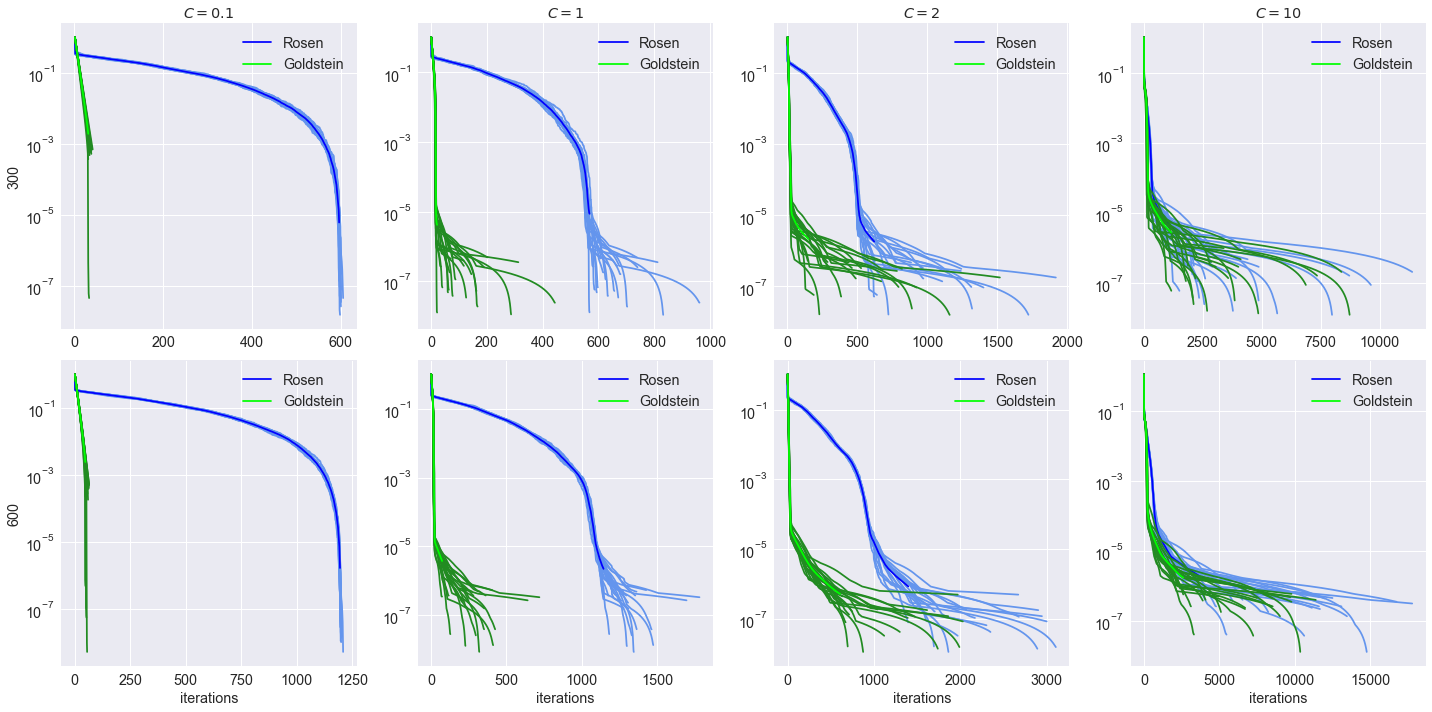

In [5]:
chosen_uppers = ['C_01EPS01', 'C_1EPS01', 'C_2EPS01', 'C_10EPS01']
chosen_sizes = [300,600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_uppers), figsize=(20,10))
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]        
        values_rosen = load_runs(f"./RUNS/ML/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS/ML/{root}", size, "gold", nproblems=20)
        
        best_values = load_external_solver_values(f"./RUNS/ML/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, c in zip(axs[0], [0.1, 1, 2, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# AIRFOIL - Upperbounds
Here we visualise the relative gap computed on the AIRFOIL dataset when varying the upperbound parameter. Epsilon was set to $0.1$ while the upperbound C assumed values in [ $0.1$, $1$, $5$, $10$ ].  We decided to insert in the report the most interesting plots, to visualise the plots with other upperbounds it suffices to insert the relative string in  the `chosen_uppers` list.

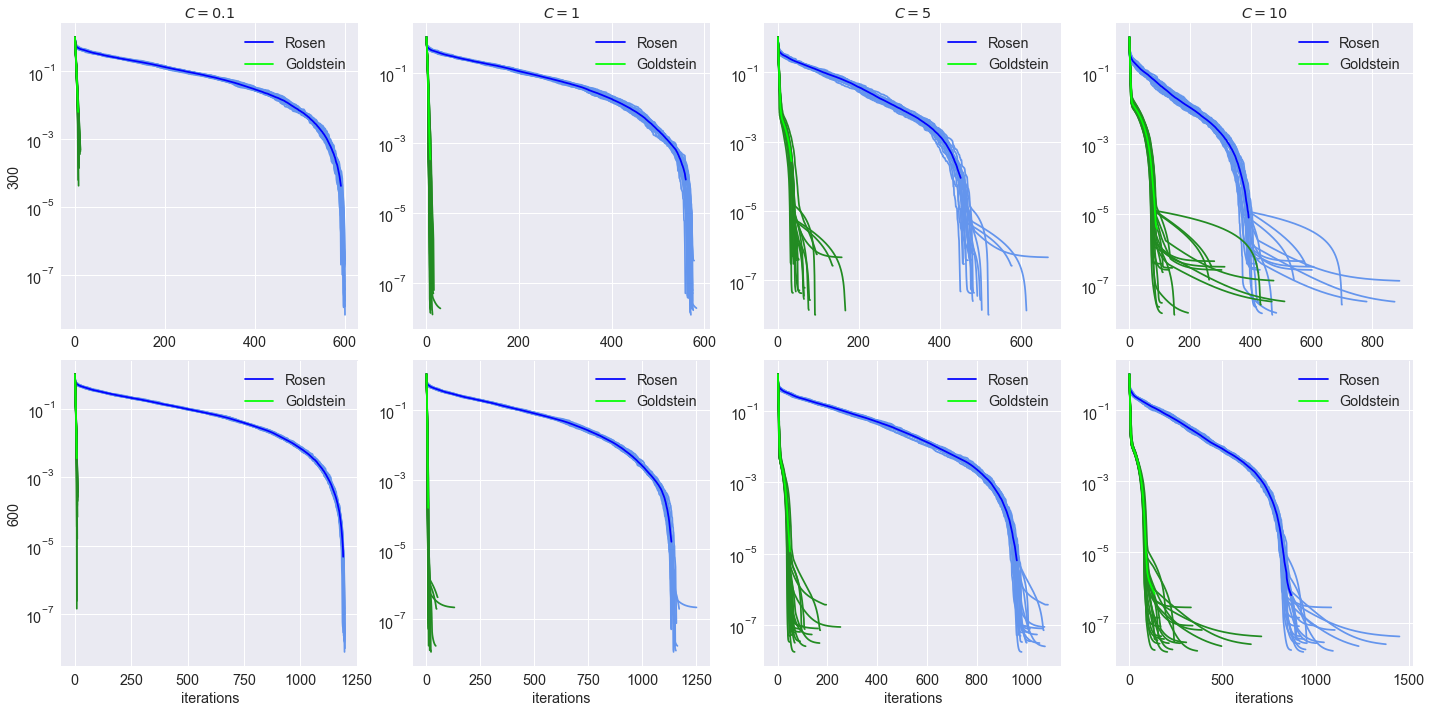

In [6]:
chosen_uppers = ['C_01EPS01', 'C_1EPS01', 'C_5EPS01', 'C_10EPS01']
chosen_sizes = [300,600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_uppers), figsize=(20,10))
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]        
        values_rosen = load_runs(f"./RUNS/AIRF/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS/AIRF/{root}", size, "gold", nproblems=20)
        
        best_values = load_external_solver_values(f"./RUNS/AIRF/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# CALIFORNIA HOUSING - UPPERBOUNDS
Here we visualise the relative gap computed on the CALIFORNIA HOUSING dataset when varying the upperbound parameter. Epsilon was set to $0.1$ while the upperbound C assumed values in [ $0.1$, $1$, $5$, $10$ ].  We decided to insert in the report the most interesting plots, to visualise the plots with other upperbounds it suffices to insert the relative string in  the `chosen_uppers` list.

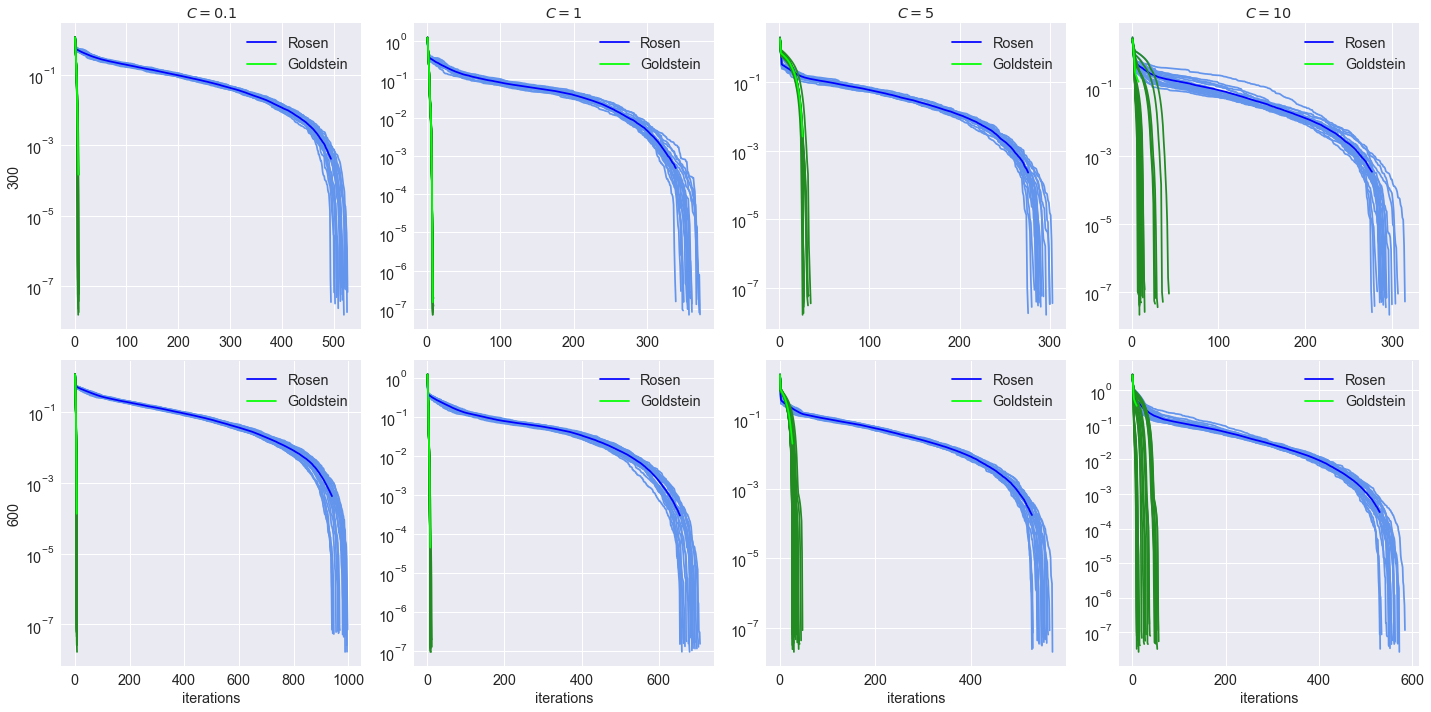

In [7]:
chosen_uppers = ['C_01EPS01', 'C_1EPS01', 'C_5EPS01', 'C_10EPS01']
chosen_sizes = [300, 600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_uppers), figsize=(20,10))
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]        
        values_rosen = load_runs(f"./RUNS/CAL/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS/CAL/{root}", size, "gold", nproblems=20)
        
        best_values = load_external_solver_values(f"./RUNS/CAL/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# $\epsilon$ experiments

In [82]:
for root, dirs, files in os.walk("./RUNS2"):
    if root == "./RUNS2/AIRF":
        chosen_epsilons_airf = list(filter(lambda x : x != 'RANDSTATES_EPS', dirs))
        print(chosen_epsilons_airf)
    
    if root == "./RUNS2/CAL":
        chosen_epsilons_cal = list(filter(lambda x : x != 'RANDSTATES_EPS', dirs))
        print(chosen_epsilons_cal)
    
    if root == "./RUNS2/ML":
        chosen_epsilons_ml = list(filter(lambda x : x != 'RANDSTATES_EPS', dirs))
        print(chosen_epsilons_ml)


['C1EPS_0-4137116338178369', 'C1EPS_0-20685581690891844', 'C1EPS_0-10342790845445922', 'C1EPS_0-020685581690891845']
['C1EPS_0-8584066570795144', 'C1EPS_0-17168133141590286', 'C1EPS_3-4336266283180574', 'C1EPS_1-7168133141590287']
['C1EPS_[24-96718856]', 'C1EPS_[12-48359428]', 'C1EPS_[6-24179714]', 'C1EPS_[1-24835943]']


In [83]:
feat, targ = load_california_dataset()
ROOT="./RUNS2/CAL/"
avg_target_cal = sum(targ) / len(targ)
if avg_target_cal < 1e-5:
    avg_target_cal = 1
epsilons_cal = [avg_target_cal * i for i in [0.01, 0.05, 0.1, 0.2]]

# CALIFORNIA - $\epsilon$

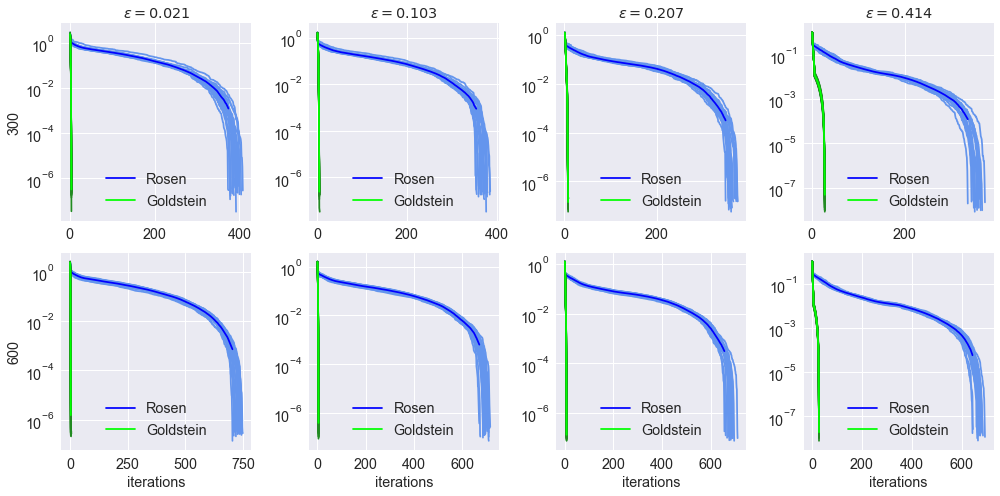

In [84]:
chosen_epsilons = chosen_epsilons_cal
chosen_sizes = [300, 600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_epsilons), figsize=(14,7))
for i,root in enumerate(chosen_epsilons):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]
        
        values_rosen = load_runs(f"./RUNS2/CAL/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS2/CAL/{root}", size, "gold", nproblems=20)
   
        best_values = load_external_solver_values(f"./RUNS2/CAL/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, eps in zip(axs[0], epsilons_cal):
    ax.set_title(f"$\epsilon = {round(eps,3)}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# AIRFOIL - $\epsilon$

In [85]:
feat, targ = load_airfoil_dataset()
targ = targ.flatten()
ROOT="./RUNS2/AIRF/"
avg_target_airf = sum(targ) / len(targ)
if avg_target_airf < 1e-5:
    avg_target_airf = 1
epsilons_airf = [avg_target_airf * i for i in [0.01, 0.05, 0.1, 0.2]]

/Users/gerardozinno/repos/ProgettoML/cm/data/airfoil_self_noise.csv


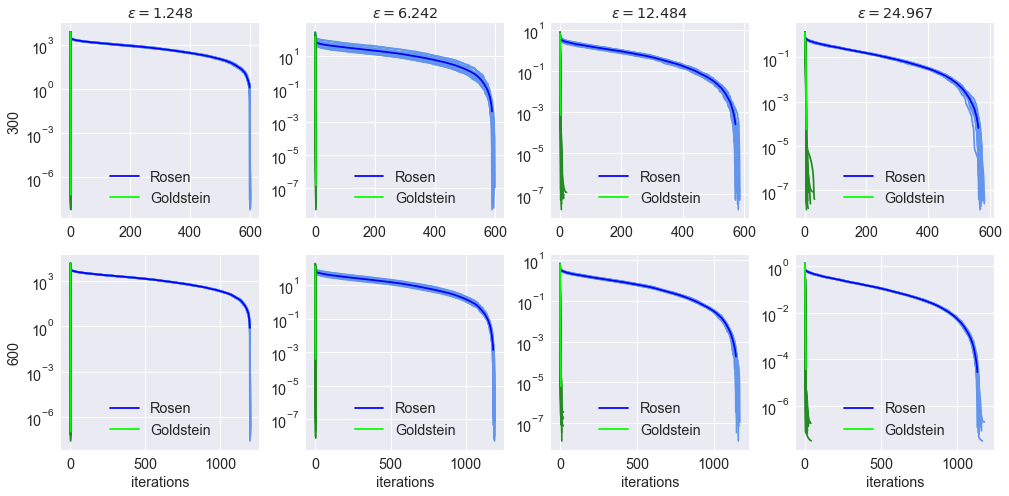

In [86]:
chosen_epsilons = chosen_epsilons_airf
chosen_sizes = [300, 600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_epsilons), figsize=(14,7))
for i,root in enumerate(chosen_epsilons):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]
        
        values_rosen = load_runs(f"./RUNS2/AIRF/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS2/AIRF/{root}", size, "gold", nproblems=20)
   
        best_values = load_external_solver_values(f"./RUNS2/AIRF/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, eps in zip(axs[0], epsilons_airf):
    ax.set_title(f"$\epsilon = {round(eps, 3)}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# ML - $\epsilon$

In [87]:
feat, targ = load_ml_dataset()
t1 = targ[:,0]
t2 = targ[:,1]
targ = t1
ROOT="./RUNS2/ML/"
avg_target_ml = sum(targ) / len(targ)

if avg_target_ml < 1e-5:
    avg_target_ml = 1
    
epsilons_ml = [avg_target_ml * i for i in [0.01, 0.05, 0.1, 0.2]]

loading from: 
/Users/gerardozinno/repos/ProgettoML/cm/data/ML-CUP19-TR.csv


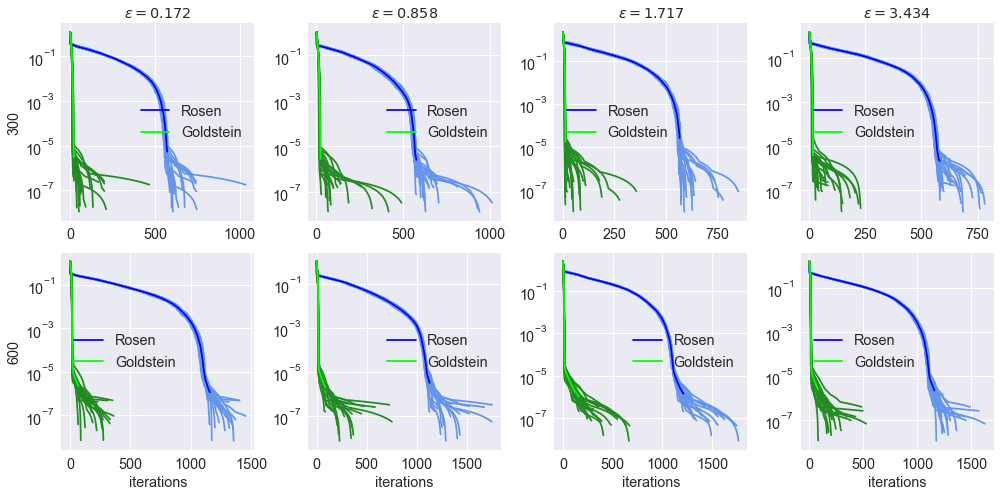

In [88]:
chosen_epsilons = chosen_epsilons_ml
chosen_sizes = [300, 600]

fig, axs = plt.subplots(nrows=len(chosen_sizes), ncols=len(chosen_epsilons), figsize=(14,7))
for i,root in enumerate(chosen_epsilons):
    for j,size in enumerate(chosen_sizes):
        ax = axs[j][i]
        
        values_rosen = load_runs(f"./RUNS2/ML/{root}", size, "rosen", nproblems=20)
        values_goldstein =  load_runs(f"./RUNS2/ML/{root}", size, "gold", nproblems=20)
   
        best_values = load_external_solver_values(f"./RUNS2/ML/{root}", size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")

        
for ax, size in zip(axs[:,0], chosen_sizes):
    ax.set_ylabel(str(size))
    
for ax, eps in zip(axs[0], epsilons_ml):
    ax.set_title(f"$\epsilon = {round(eps, 3)}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# ISOLATED PLOTS
We also visualise the behaviour of Goldstein's and Rosen's algorithms with the same parameters on the three datasets.  

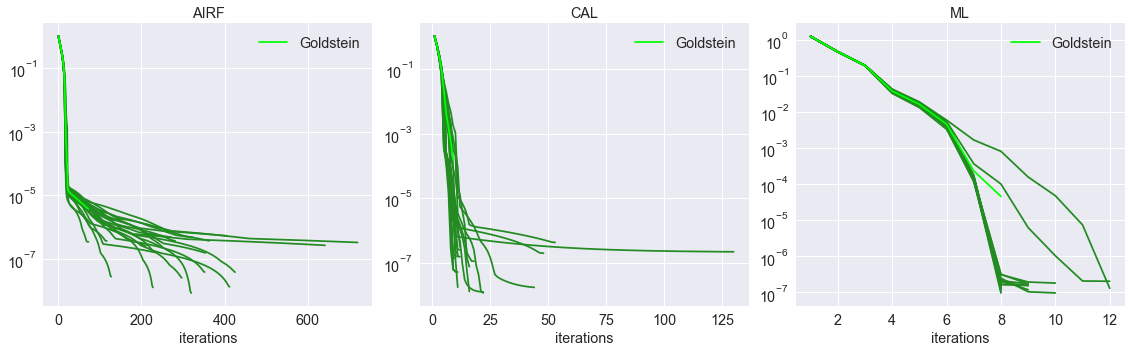

In [11]:
ALG = "GOLD"
size = 600
root = 'C_1EPS01'
datasets = ['ML', 'AIRF', 'CAL']

fig, axs = plt.subplots(ncols=len(datasets), figsize=(16,5))
for i, data in enumerate(datasets):
    ax = axs[i]
          
    values = load_runs(f"./RUNS/{data}/{root}", size, ALG, nproblems=20)

    best_values = load_external_solver_values(f"./RUNS/{data}/{root}", size)

    values = [relative_gap(i, opt) for i, opt in zip(values, best_values)]

    plot_multiple_functions(values, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
    ax.set_yscale("log")

    
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

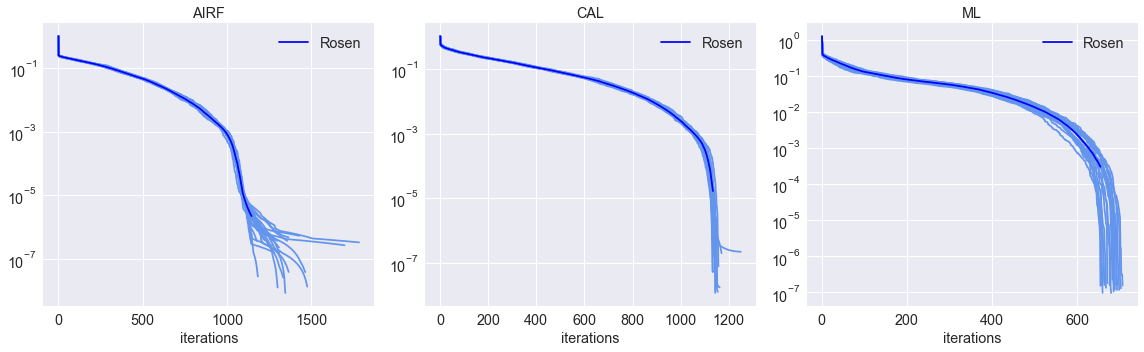

In [12]:
ALG = "ROS"
size = 600
root = 'C_1EPS01'
datasets = ['ML', 'AIRF', 'CAL']

fig, axs = plt.subplots(ncols=len(datasets), figsize=(16,5))
for i, data in enumerate(datasets):
    ax = axs[i]
          
    values = load_runs(f"./RUNS/{data}/{root}", size, ALG, nproblems=20)

    best_values = load_external_solver_values(f"./RUNS/{data}/{root}", size)

    values = [relative_gap(i, opt) for i, opt in zip(values, best_values)]

    plot_multiple_functions(values, plot_avg=True, ax=ax, label="Rosen")
    ax.set_yscale("log")

    
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

# CONVERGENCE RESULTS
The following section contains the results about the convergence rate of the two algorithms.

In [13]:
epsilons
upperbounds
size = 600
root = 'C_1EPS01'

for each dataset we reload the evolution of the function value at each iteration, along with the esternal solver's optimal values and compute the convergence rate plots.

In [14]:
gold_values_ml = load_runs(f"./RUNS/ML/{root}", size, "gold", nproblems=20)
ros_values_ml = load_runs(f"./RUNS/ML/{root}", size, "rosen", nproblems=20)
best_values_ml = best_values = load_external_solver_values(f"./RUNS/ML/{root}", size)
gold_conv_rate_ml = convergence_rate(gold_values_ml, best_values_ml)
ros_conv_rate_ml = convergence_rate(ros_values_ml, best_values_ml)

gold_values_airf = load_runs(f"./RUNS/AIRF/{root}", size, "gold", nproblems=20)
ros_values_airf = load_runs(f"./RUNS/AIRF/{root}", size, "rosen", nproblems=20)
best_values_airf = best_values = load_external_solver_values(f"./RUNS/AIRF/{root}", size)
gold_conv_rate_airf = convergence_rate(gold_values_airf, best_values_airf)
ros_conv_rate_airf = convergence_rate(ros_values_airf, best_values_airf)

gold_values_cal = load_runs(f"./RUNS/CAL/{root}", size, "gold", nproblems=20)
ros_values_cal = load_runs(f"./RUNS/CAL/{root}", size, "rosen", nproblems=20)
best_values_cal = best_values = load_external_solver_values(f"./RUNS/CAL/{root}", size)
gold_conv_rate_cal = convergence_rate(gold_values_cal, best_values_cal)
ros_conv_rate_cal = convergence_rate(ros_values_cal, best_values_cal)

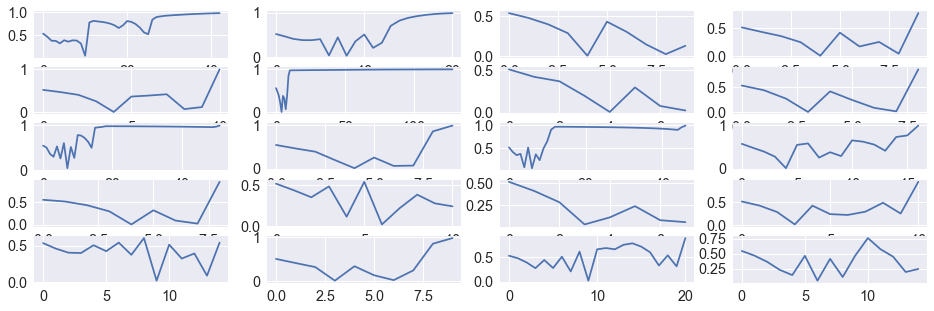

In [15]:
conv = gold_conv_rate_airf

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16,5))
for i in range(5):
    for j in range(4):
        idx = 4*i + j
        axs[i][j].plot(range(len(conv[idx])), conv[idx])

from the plots above we select two representative subplots to insert in the report.

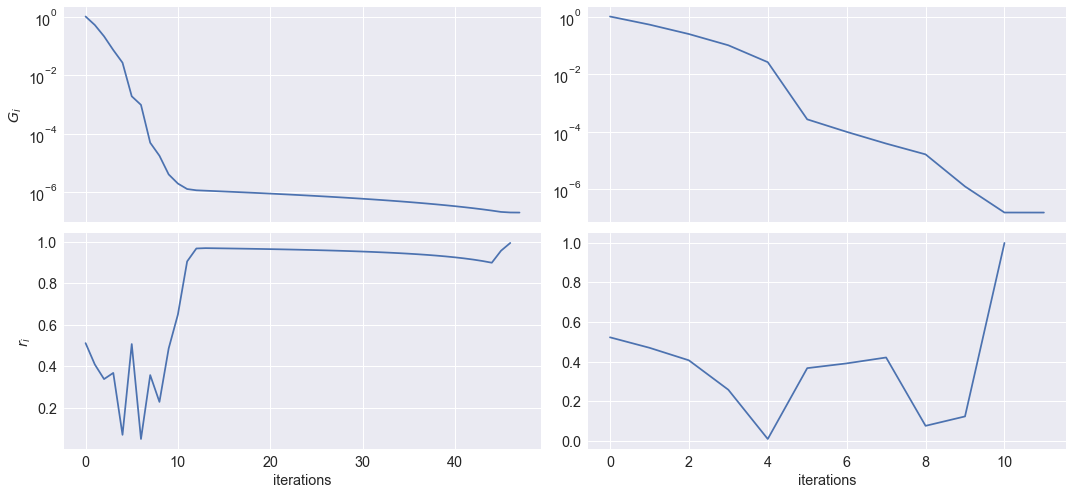

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(15,7))
conv = gold_conv_rate_airf
vals = [relative_gap(v, b) for v, b in zip(gold_values_airf, best_values_airf)]
####
idx = 10
axs[0][0].plot(range(len(vals[idx])), vals[idx])
axs[0][0].set_yscale("log")
axs[1][0].plot(range(len(conv[idx])), conv[idx])
####
idx = 4
axs[0][1].plot(range(len(vals[idx])), vals[idx])
axs[0][1].set_yscale("log")
axs[1][1].plot(range(len(conv[idx])), conv[idx])
###
axs[1][0].set_xlabel("iterations")
axs[1][1].set_xlabel("iterations")

axs[0][0].set_ylabel("$G_i$")
axs[1][0].set_ylabel("$r_i$")

plt.tight_layout()

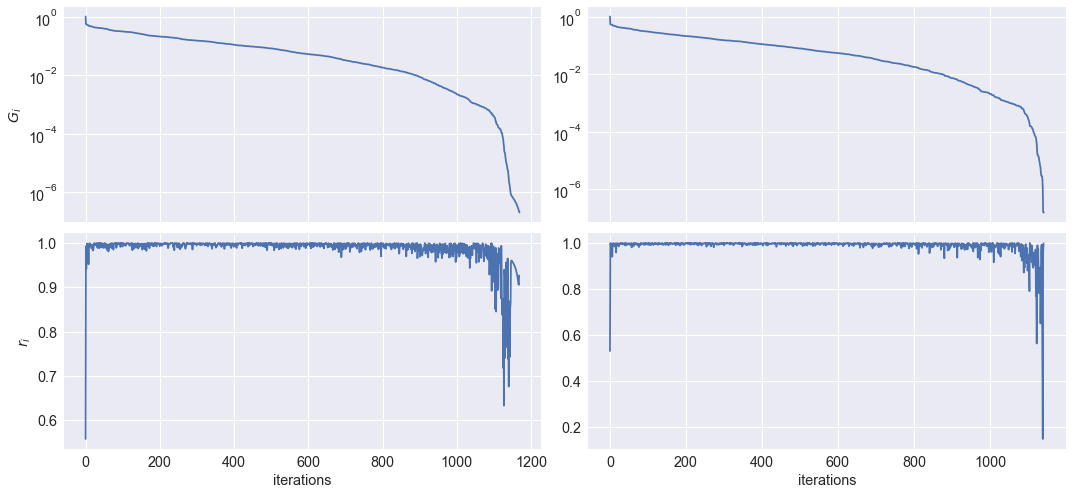

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(15,7))
conv = ros_conv_rate_airf
vals = [relative_gap(v, b) for v, b in zip(ros_values_airf, best_values_airf)]
####
idx = 10
axs[0][0].plot(range(len(vals[idx])), vals[idx])
axs[0][0].set_yscale("log")
axs[1][0].plot(range(len(conv[idx])), conv[idx])
####
idx = 4
axs[0][1].plot(range(len(vals[idx])), vals[idx])
axs[0][1].set_yscale("log")
axs[1][1].plot(range(len(conv[idx])), conv[idx])
###
axs[1][0].set_xlabel("iterations")
axs[1][1].set_xlabel("iterations")

axs[0][0].set_ylabel("$G_i$")
axs[1][0].set_ylabel("$r_i$")

plt.tight_layout()

# ALPHAS
In this rection we analyse the algorithm's behavion when we change the alpha parameter, corresponding to the stepsize along the anti-gradient before computing the projection.

In [18]:
def relative_gap_alpha(alphas, opts):
    new_alphas = []
    for alpha in alphas:
        new_alpha = []
        for run, opt in zip(alpha, opts):
            new_alpha.append((run - opt) / abs(opt))
        new_alphas.append(np.array(new_alpha))
    return new_alphas

In [19]:
basedir = "./RUNS/{}/ALPHA"
nproblems = 5
alphas = [0.1, 0.5, 1, 2, 5]

## CALIFORNIA

In [20]:
california_alphas_path = basedir.format("CAL")
# lista di liste di array
# prima lista = alphas
# seconda lista = runs
# array = singola run
a_strings = [str(a).replace(".", "") for a in alphas]
calif_alpha_list = [load_alpha_runs(f"{california_alphas_path}/{a}", 20) for a in a_strings]

In [21]:
#calif_alphas = []
calif_alphas = list(zip(*calif_alpha_list))
calif_alphas = [list(l) for l in calif_alphas]
california_optimal_values = load_external_solver_alphas("./RUNS/CAL/ALPHA")

In [22]:
calif_transformed_values = relative_gap_alpha(calif_alpha_list, california_optimal_values)

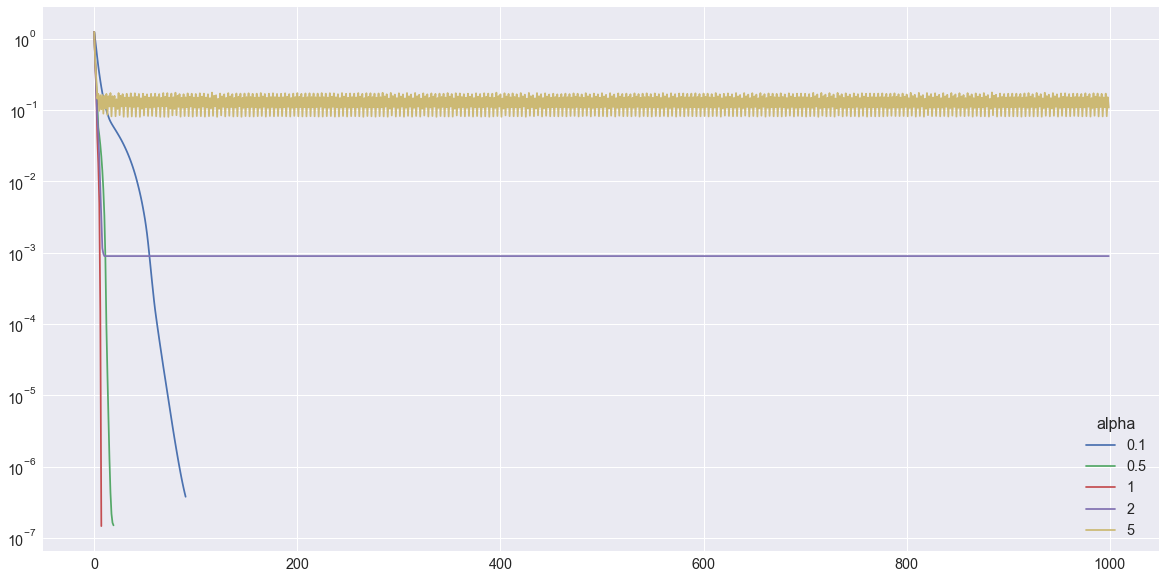

In [60]:
for alpha in range(len(alphas)):
    # (run, alpha)
    plt.plot(calif_transformed_values[alpha][0], label=str(alphas[alpha]))
plt.gca().set_yscale("log")
#plt.gca().set_xlim(0,50)
#plt.gca().set_ylim(1e-4,0)
plt.legend(title="alpha", title_fontsize=16)

## ML

In [24]:
ml_alphas_path = basedir.format("ML")
# lista di liste di array
# prima lista = alphas
# seconda lista = runs
# array = singola run
a_strings = [str(a).replace(".", "") for a in alphas]
ml_alpha_list = [load_alpha_runs(f"{ml_alphas_path}/{a}", 20) for a in a_strings]

In [25]:
ml_alphas = list(zip(*ml_alpha_list))
ml_alphas = [list(l) for l in ml_alphas]
ml_optimal_values = load_external_solver_alphas("./RUNS/ML/ALPHA")

In [26]:
ml_transformed_values = relative_gap_alpha(ml_alpha_list, ml_optimal_values)

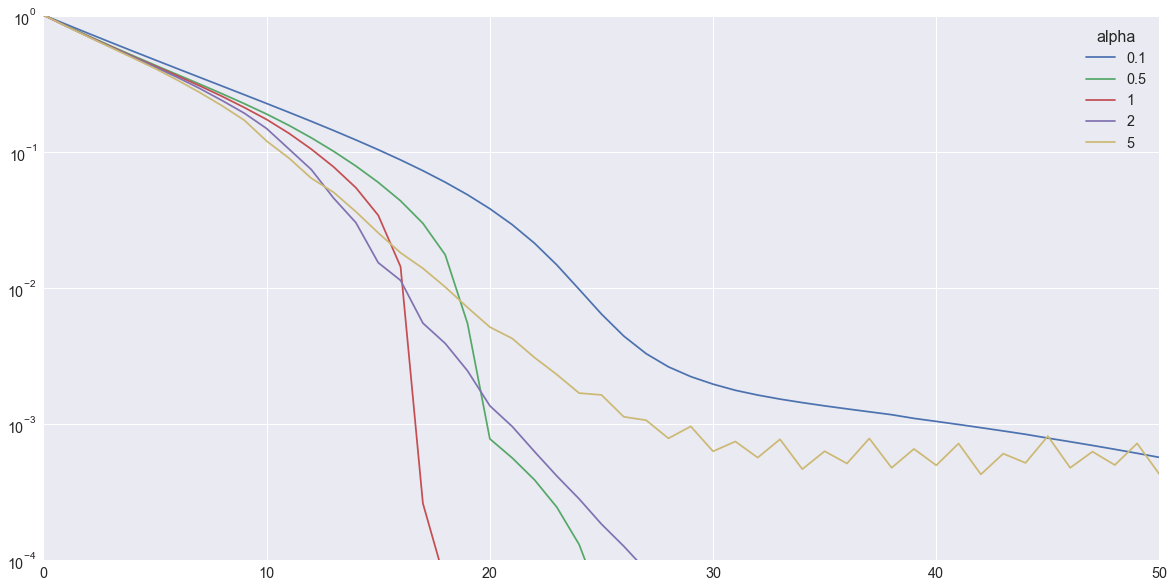

In [92]:
for alpha in range(len(alphas)):
    # (run, alpha)
    plt.plot(ml_transformed_values[alpha][14], label=str(alphas[alpha]))
    
plt.gca().set_yscale("log")
plt.gca().set_xlim(0,50)
plt.gca().set_ylim(1e-4,1)
plt.legend(title="alpha", title_fontsize=16)

## AIRFOIL

In [28]:
airf_alphas_path = basedir.format("AIRF")
# lista di liste di array
# prima lista = alphas
# seconda lista = runs
# array = singola run
a_strings = [str(a).replace(".", "") for a in alphas]
airf_alpha_list = [load_alpha_runs(f"{airf_alphas_path}/{a}", 20) for a in a_strings]
airf_optimal_values = load_external_solver_alphas("./RUNS/AIRF/ALPHA")

In [29]:
airf_transformed_values = relative_gap_alpha(airf_alpha_list, airf_optimal_values)

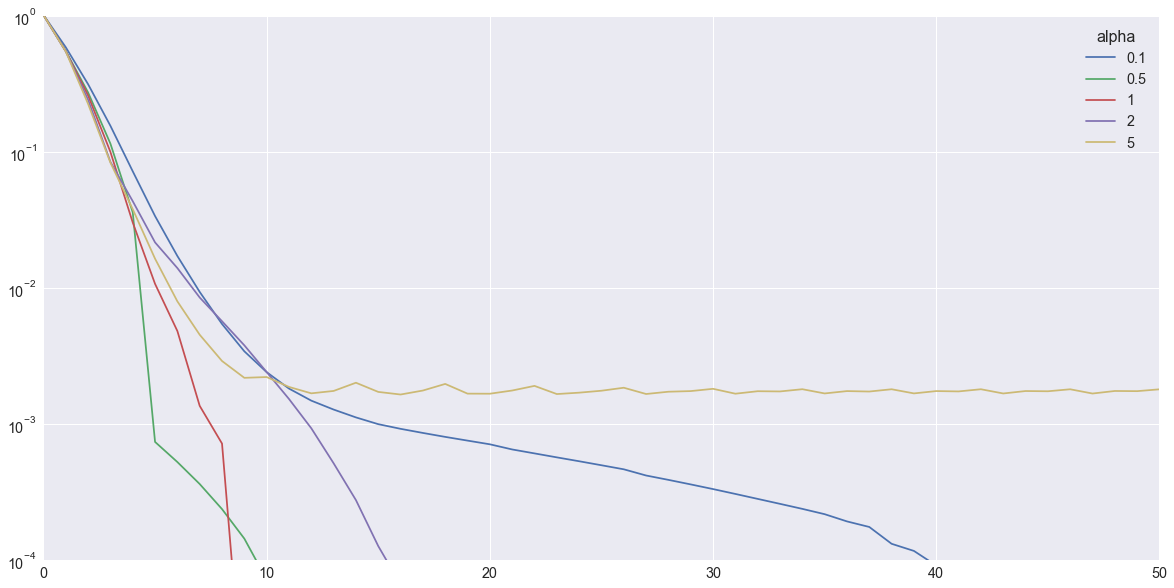

In [91]:
for alpha in range(len(alphas)):
    # (run, alpha)
    plt.plot(airf_transformed_values[alpha][0], label=str(alphas[alpha]))
plt.gca().set_yscale("log")
plt.gca().set_xlim(0,50)
plt.gca().set_ylim(1e-4,1)
plt.legend(title="alpha", title_fontsize=16)

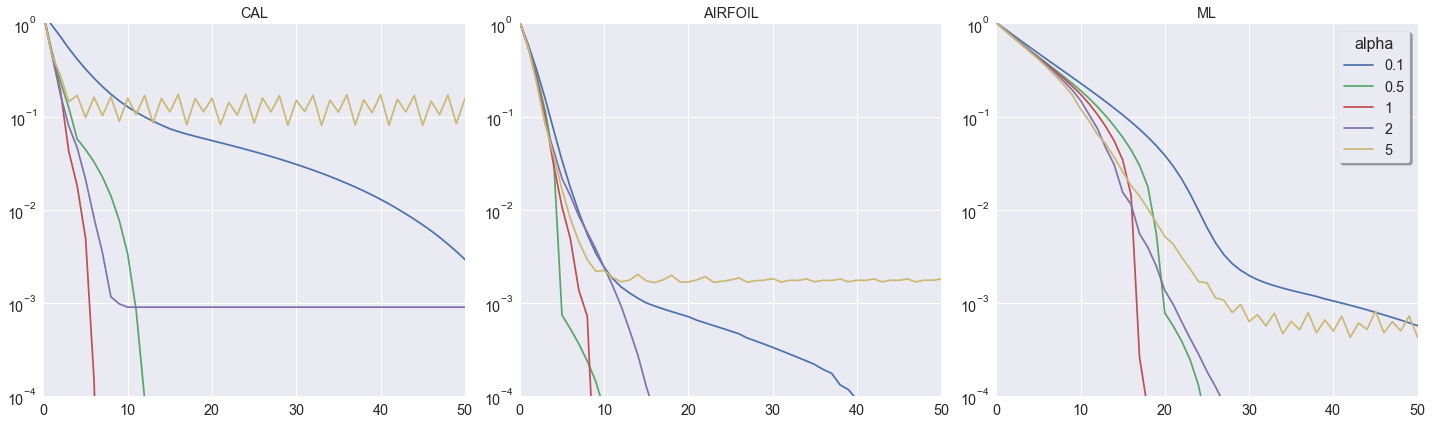

In [59]:
fig, axs = plt.subplots(ncols=3, figsize=(20,6))

## CAL
for alpha in range(len(alphas)):
    # (run, alpha)
    axs[0].plot(calif_transformed_values[alpha][0], label=str(alphas[alpha]))
axs[0].set_title("CAL")
axs[0].set_yscale("log")
axs[0].set_xlim(0,50)
axs[0].set_ylim(1e-4,1)


### AIRF
for alpha in range(len(alphas)):
    # (run, alpha)
    axs[1].plot(airf_transformed_values[alpha][0], label=str(alphas[alpha]))
axs[1].set_title("AIRFOIL")
axs[1].set_yscale("log")
axs[1].set_xlim(0,50)
axs[1].set_ylim(1e-4,1)

### ML
for alpha in range(len(alphas)):
    # (run, alpha)
    axs[2].plot(ml_transformed_values[alpha][14], label=str(alphas[alpha]))

axs[2].set_title("ML")
axs[2].set_yscale("log")
axs[2].set_xlim(0,50)
axs[2].set_ylim(1e-4,1)

axs[2].legend(frameon=True, fancybox=True, shadow=True, title="alpha", title_fontsize=16)
plt.tight_layout()

# Real Problems
Here there are the results of the algorithms on the whole airfoil dataset and one third of the california housing dataset. We used only one third of the california housing dataset due to its size which didn't fit in memory after the problem transformation.

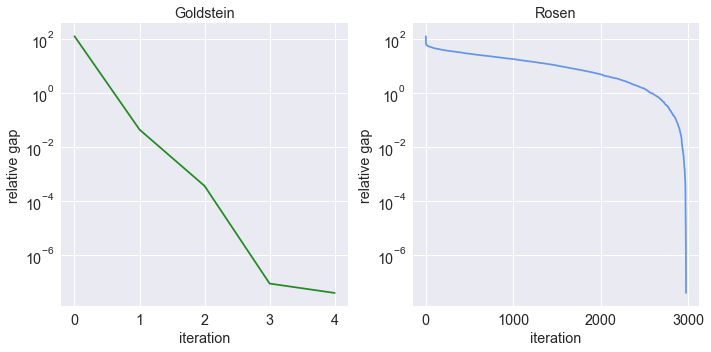

In [89]:
airf_gold = pd.read_csv("./AIRFOIL_GOLDSTEIN_C1.csv", usecols=['val']).to_numpy()
airf_ros = pd.read_csv("./AIRFOIL_ROSEN_C1.csv", usecols=['val']).to_numpy()

airf_opt = None
with open("./AIRFOIL_C1_optimalvalue.txt", "r") as f:
    airf_opt = np.float64(f.readlines()[0])

airf_gold_rg = relative_gap(airf_gold, airf_opt)
airf_ros_rg = relative_gap(airf_ros, airf_opt)


fig, axs = plt.subplots(ncols=2, figsize=(10,5))

axs[0].plot(airf_gold_rg, color='forestgreen', label="goldstein")
axs[1].plot(airf_ros_rg, color='cornflowerblue', label="rosen")
axs[0].set(yscale='log', xlabel='iteration', ylabel="relative gap", title="Goldstein")
axs[1].set(yscale='log', xlabel='iteration', ylabel="relative gap", title="Rosen")

plt.tight_layout()

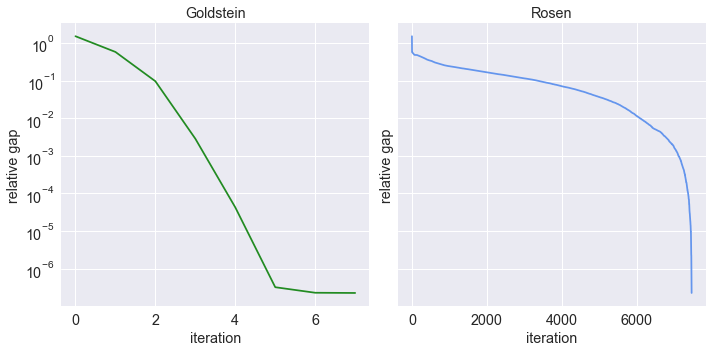

In [90]:
cal_gold = pd.read_csv("./CALIF_GOLDSTEIN_C1.csv", usecols=['val']).to_numpy()
cal_ros = pd.read_csv("./CALIF_ROSEN_C1.csv", usecols=['val']).to_numpy()

cal_opt = None
with open("./CALIF_C1_optimalvalue.txt", "r") as f:
    cal_opt = np.float64(f.readlines()[0])

cal_gold_rg = relative_gap(cal_gold, cal_opt)
cal_ros_rg = relative_gap(cal_ros, cal_opt)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

axs[0].plot(cal_gold_rg, color='forestgreen', label="goldstein")
axs[1].plot(cal_ros_rg, color='cornflowerblue', label="rosen")
axs[0].set(yscale='log', xlabel='iteration', ylabel="relative gap", title="Goldstein")
axs[1].set(yscale='log', xlabel='iteration', ylabel="relative gap", title="Rosen")

plt.tight_layout()